In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d yasserhessein/the-vertebrae-xray-images

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/the-vertebrae-xray-images
License(s): CC-BY-SA-4.0


In [ ]:
!unzip the-vertebrae-xray-images.zip -d vertebrae_xray_data

Archive:  the-vertebrae-xray-images.zip
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N1,N,40,M_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N1,N,F,21_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N11,N,F,26_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N12,N,F,14_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N12,N,M,13_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N13,N,F,15_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N16,N,M,17_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N17,N,M,19_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N18,N,F,13_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N18,N,M,11_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal/N19,N,M,19_1_0.jpg  
  inflating: vertebrae_xray_data/xkt857dsxk-1/224/224/Normal

In [ ]:
!pip install tensorflow numpy matplotlib scikit-learn

In [ ]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define paths to original images from Kaggle
scoliosis_path_kaggle = 'vertebrae_xray_data/xkt857dsxk-1/ImagesOriginalSize/ScolFinal'
normal_path_kaggle = 'vertebrae_xray_data/xkt857dsxk-1/ImagesOriginalSize/NormalFinal'

# Define paths to original images from Google Drive
scoliosis_path_drive = '/content/drive/MyDrive/DATA/Scoliosis'
normal_path_drive = '/content/drive/MyDrive/DATA/Normal'

# Function to delete existing directories
def delete_directory(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)

# Delete both the 'dataset' and 'dataset_split' directories at the beginning of the process
delete_directory('dataset_split')
delete_directory('dataset')

# Create directories for the dataset in 'dataset_split'
os.makedirs('dataset_split/scoliosis_images', exist_ok=True)
os.makedirs('dataset_split/normal_images', exist_ok=True)

# Copy scoliosis images from Kaggle
for img_file in os.listdir(scoliosis_path_kaggle):
    shutil.copy(os.path.join(scoliosis_path_kaggle, img_file), 'dataset_split/scoliosis_images/')

# Copy normal images from Kaggle
for img_file in os.listdir(normal_path_kaggle):
    shutil.copy(os.path.join(normal_path_kaggle, img_file), 'dataset_split/normal_images/')

# Copy scoliosis images from Google Drive
for img_file in os.listdir(scoliosis_path_drive):
    shutil.copy(os.path.join(scoliosis_path_drive, img_file), 'dataset_split/scoliosis_images/')

# Copy normal images from Google Drive
for img_file in os.listdir(normal_path_drive):
    shutil.copy(os.path.join(normal_path_drive, img_file), 'dataset_split/normal_images/')

# Get the number of images in each category
num_scoliosis = len(os.listdir('dataset_split/scoliosis_images'))
num_normal = len(os.listdir('dataset_split/normal_images'))

print(f'Number of scoliosis images: {num_scoliosis}')
print(f'Number of normal images: {num_normal}')

# Create the new directory 'aug_dataset' for the augmented dataset
os.makedirs('aug_dataset/scol', exist_ok=True)
os.makedirs('aug_dataset/norm', exist_ok=True)

# Delete any existing files in 'aug_dataset/norm' to avoid duplicate images
delete_directory('aug_dataset/norm')

# Recreate the 'aug_dataset/norm' directory after deletion
os.makedirs('aug_dataset/norm', exist_ok=True)

# Copy the 358 scoliosis images into 'aug_dataset/scol'
for img_file in os.listdir('dataset_split/scoliosis_images'):
    shutil.copy(os.path.join('dataset_split/scoliosis_images', img_file), 'aug_dataset/scol/')

# Balance the dataset by augmenting normal images only if needed
if num_normal < num_scoliosis:
    print("Balancing the dataset by augmenting normal images...")

    # Only augment if needed, ensuring that augmentation happens just once.
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Load normal images and augment them if needed
    normal_images = os.listdir('dataset_split/normal_images')
    num_augmented = 0
    target_num_normal = num_scoliosis

    # Only augment if needed and stop when target count is reached
    if num_normal < target_num_normal:
        while num_normal + num_augmented < target_num_normal:
            img_file = np.random.choice(normal_images)
            img_path = os.path.join('dataset_split/normal_images', img_file)
            img = tf.keras.utils.load_img(img_path)
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            # Create augmented images
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir='dataset_split/normal_images', save_prefix='aug', save_format='jpg'):
                num_augmented += 1
                if num_normal + num_augmented >= target_num_normal:
                    break

        print(f"Number of normal images after augmentation: {num_normal + num_augmented}")

# Copy the original and augmented normal images into 'aug_dataset/norm'
for img_file in os.listdir('dataset_split/normal_images'):
    img_path = os.path.join('dataset_split/normal_images', img_file)
    # Ensure that only files are copied, not directories
    if os.path.isfile(img_path):
        shutil.copy(img_path, 'aug_dataset/norm/')

print("Scoliosis and Normal images (original + augmented) copied to 'aug_dataset'.")

# Split the dataset into training, validation, and test sets

# Create lists of file paths
scoliosis_images = [os.path.join('dataset_split/scoliosis_images', img) for img in os.listdir('dataset_split/scoliosis_images')]
normal_images = [os.path.join('dataset_split/normal_images', img) for img in os.listdir('dataset_split/normal_images')]

# Combine and label the data
all_images = scoliosis_images + normal_images
labels = [1] * len(scoliosis_images) + [0] * len(normal_images)

# Split into training (80%), validation (10%), and testing (10%)
x_train, x_temp, y_train, y_temp = train_test_split(all_images, labels, test_size=0.2, random_state=42, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset distribution
print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_val)}')
print(f'Test set size: {len(x_test)}')

# Create directories for training, validation, and test sets in 'dataset_split'
os.makedirs('dataset_split/train/scoliosis', exist_ok=True)
os.makedirs('dataset_split/train/normal', exist_ok=True)
os.makedirs('dataset_split/validation/scoliosis', exist_ok=True)
os.makedirs('dataset_split/validation/normal', exist_ok=True)
os.makedirs('dataset_split/test/scoliosis', exist_ok=True)
os.makedirs('dataset_split/test/normal', exist_ok=True)

# Function to copy images to their respective directories in 'dataset_split'
def copy_images(image_paths, labels, dest_dir):
    for img_path, label in zip(image_paths, labels):
        category = 'scoliosis' if label == 1 else 'normal'
        shutil.copy(img_path, os.path.join(dest_dir, category))

# Copy images to respective directories in 'dataset_split'
copy_images(x_train, y_train, 'dataset_split/train')
copy_images(x_val, y_val, 'dataset_split/validation')
copy_images(x_test, y_test, 'dataset_split/test')

print("Training, validation, and test datasets prepared in 'dataset_split'.")

# Clean up any unnecessary folders like 'scoliosis_images' and 'normal_images' from 'dataset_split'
shutil.rmtree('dataset_split/scoliosis_images')
shutil.rmtree('dataset_split/normal_images')
print("Unnecessary directories removed.")


Number of scoliosis images: 358
Number of normal images: 258
Balancing the dataset by augmenting normal images...
Number of normal images after augmentation: 358
Scoliosis and Normal images (original + augmented) copied to 'aug_dataset'.
Training set size: 572
Validation set size: 72
Test set size: 72
Training, validation, and test datasets prepared in 'dataset_split'.
Unnecessary directories removed.


In [ ]:
import os

# Define the paths to the 'scoliosis' and 'normal' directories
test_count_norm = 'dataset_split/test/normal'
test_count_scol = 'dataset_split/test/scoliosis'
val_count_norm = 'dataset_split/validation/normal'
val_count_scol = 'dataset_split/validation/scoliosis'
train_count_norm = 'dataset_split/train/normal'
train_count_scol = 'dataset_split/train/scoliosis'
# Get the list of image files in each directory
test_norm = os.listdir(test_count_norm)
test_scol = os.listdir(test_count_scol)
val_norm = os.listdir(val_count_norm)
val_scol = os.listdir(val_count_scol)
train_norm = os.listdir(train_count_norm)
train_scol = os.listdir(train_count_scol)

# Count the number of images in each category
num_test_norm = len(test_norm)
num_test_scol = len(test_scol)
num_val_norm = len(val_norm)
num_val_scol = len(val_scol)
num_train_norm = len(train_norm)
num_train_scol = len(train_scol)

# Print the counts
print(f"Number of Normal Train images: {num_train_norm}")
print(f"Number of Scoliosis Train images: {num_train_scol}")
print(f"Number of Normal Val images: {num_val_norm}")
print(f"Number of Scoliosis Val images: {num_val_scol}")
print(f"Number of Normal Test images: {num_test_norm}")
print(f"Number of Scoliosis Test images: {num_test_scol}")




Number of Normal Train images: 286
Number of Scoliosis Train images: 286
Number of Normal Val images: 36
Number of Scoliosis Val images: 36
Number of Normal Test images: 36
Number of Scoliosis Test images: 36


In [ ]:
import os
aug_norm_c = 'aug_dataset/norm'
aug_scol_c = 'aug_dataset/scol'

aug_norm_co= os.listdir(aug_norm_c)
aug_scol_co= os.listdir(aug_scol_c)

num_aug_norm = len(aug_norm_co)
num_aug_scol = len(aug_scol_co)

print(f"Number of Normal Train images: {num_aug_norm}")
print(f"Number of Scoliosis Train images: {num_aug_scol}")

Number of Normal Train images: 358
Number of Scoliosis Train images: 358


Checking dataset folder structure...
['test', 'train', 'validation']
Found 571 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6482 - loss: 1.2149 - val_accuracy: 0.7656 - val_loss: 0.5074
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7500 - loss: 0.5557

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.7500 - loss: 0.5557 - val_accuracy: 0.8438 - val_loss: 0.3752
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 981ms/step - accuracy: 0.8380 - loss: 0.3558 - val_accuracy: 0.8750 - val_loss: 0.2728
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.8889 - loss: 0.3633 - val_accuracy: 0.8906 - val_loss: 0.2531
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8484 - loss: 0.3499 - val_accuracy: 0.8906 - val_loss: 0.2874
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9062 - loss: 0.3750 - val_accuracy: 0.8906 - val_loss: 0.2488
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step - accuracy: 0.8813 - loss: 0.3167 - val_accuracy: 0.8750 - val_loss: 0.3714
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9062 - loss: 0.1887 - val_accuracy: 0.9375 - val_loss: 0.2068
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9223 - loss: 0.1970 - val_accuracy: 0.8906 - val_lo

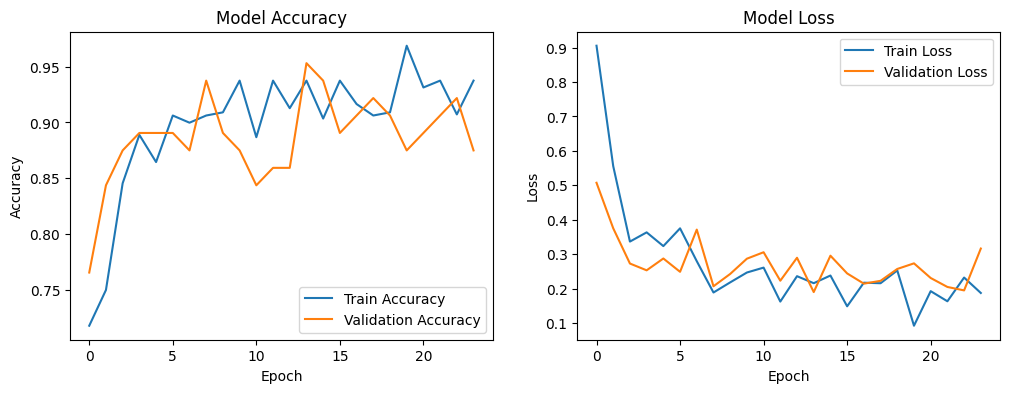

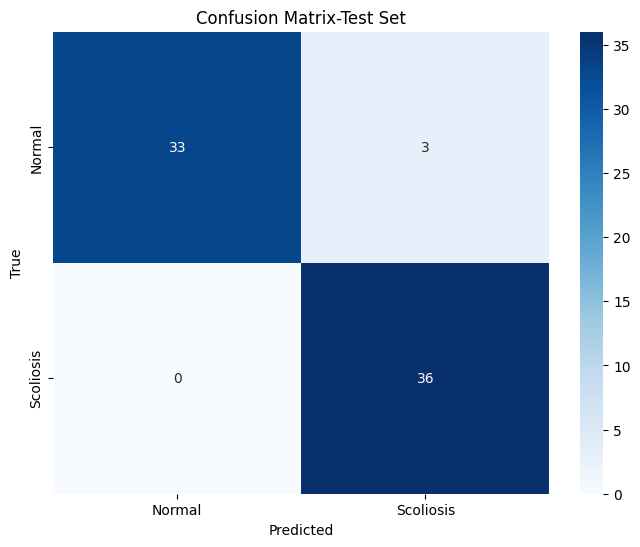

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns

# Dataset path (Update to match your dataset structure)
dataset_path = 'dataset_split'

# Verify the folder structure
print("Checking dataset folder structure...")
print(os.listdir(dataset_path))

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Image data generators without validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator without validation split
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True  # Shuffle the training data
)

# Validation generator without validation split
val_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Keep the validation set order intact
)

# Test generator remains the same
test_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Model definition using InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification (Normal vs Scoliosis)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Define and compile model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('scoliosis_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Use the number of samples divided by the batch size
    validation_steps=val_generator.samples // batch_size,  # Same for validation
    callbacks=[early_stopping, model_checkpoint]
)

# Final evaluation on the test set
test_results = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}')

# Generate predictions on the test set
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)
y_true = test_generator.classes

# Classification report and confusion matrix for test set
print("Classification Report on Test Data:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix on Test Data:")
print(confusion_matrix(y_true, y_pred))

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Save the model after training
model.save('final_scoliosis_model.keras')

# Save confusion matrix plot
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scoliosis'], yticklabels=['Normal', 'Scoliosis'])
plt.title('Confusion Matrix-Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the plot as an image
plt.savefig('confusion_matrix.png')

# Show the plot
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 747ms/step
Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.89      0.89      0.89        36

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72

Confusion Matrix on Validation Data:
[[32  4]
 [ 4 32]]


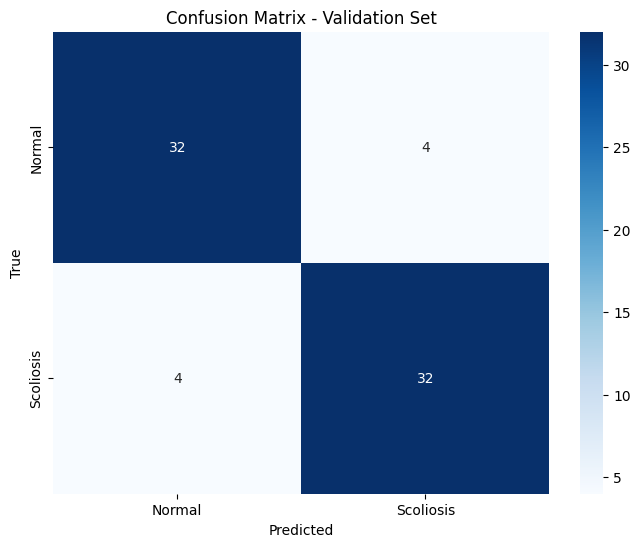

In [ ]:
# Generate predictions on the validation set
val_pred_probs = model.predict(val_generator)
val_pred = (val_pred_probs > 0.5).astype("int32")
val_true = val_generator.classes

# Classification report and confusion matrix for validation set
print("Classification Report on Validation Data:")
print(classification_report(val_true, val_pred))
print("Confusion Matrix on Validation Data:")
val_cm = confusion_matrix(val_true, val_pred)
print(val_cm)

# Plot confusion matrix for validation data using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scoliosis'], yticklabels=['Normal', 'Scoliosis'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_validation.png')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.9195 - loss: 0.2352
Test Loss: 0.28586286306381226, Test Accuracy: 0.9014084339141846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


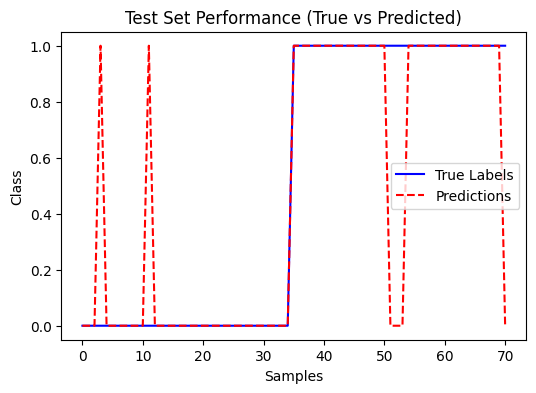

In [ ]:
# After training, evaluate on the test set
test_results = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}')

# Generate predictions for the test set
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)
y_true = test_generator.classes

# Plotting the test set performance (Optional)
plt.figure(figsize=(6, 4))
plt.plot(y_true, label='True Labels', color='blue')
plt.plot(y_pred, label='Predictions', color='red', linestyle='dashed')
plt.title('Test Set Performance (True vs Predicted)')
plt.ylabel('Class')
plt.xlabel('Samples')
plt.legend()
plt.show()


In [ ]:
model_save_path = '/content/drive/My Drive/final_scoliosis_model.keras'
model.save(model_save_path)


Saving 000355.jpg to 000355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The model predicts: Scoliosis


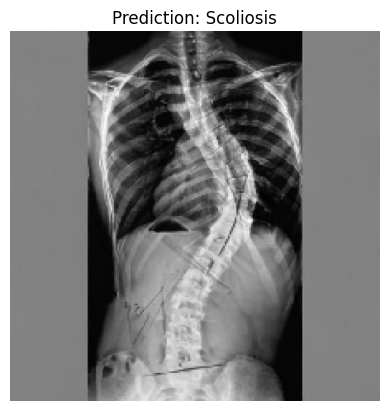

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Upload an image
uploaded = files.upload()

# Step 2: Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to the model's expected input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

# Step 3: Load your trained model
model = tf.keras.models.load_model('/content/drive/My Drive/final_scoliosis_model.keras')  # Replace with the actual path to your model

# Step 4: Make a prediction and display results
for file_name in uploaded.keys():
    img_path = file_name
    img_array = load_and_preprocess_image(img_path)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.5).astype("int32")  # Threshold for binary classification

    # Display the result
    if predicted_class[0][0] == 1:
        print("The model predicts: Scoliosis")
    else:
        print("The model predicts: Normal")

    # Plot the image with the prediction
    img = image.load_img(img_path, target_size=(224, 224))  # Reload image for display
    plt.imshow(img)
    plt.title(f"Prediction: {'Scoliosis' if predicted_class[0][0] == 1 else 'Normal'}")
    plt.axis('off')
    plt.show()
